In [1]:
import os 
import sys 
from SourceFiles.teproteus import TEProteusAdmin as TepAdmin
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# connect
admin = TepAdmin() #required to control PXI module
sid = 8 #PXI slot WDS found
inst = admin.open_instrument(slot_id=sid)
resp = inst.send_scpi_query("*IDN?")
print('connected to: ' + resp) # Print *IDN

Load TEProteus.dll from : C:\Windows\system32\TEProteus.dll
connected to: Tabor Electronics,P9484M,000002243278,1.237.0 --slot#: 8,


In [1]:
# initialize
inst.send_scpi_cmd('*CLS; *RST')

NameError: name 'inst' is not defined

In [4]:
resp=inst.send_scpi_query(':SYST:ERR?')

print(resp)

0, no error


In [164]:
2400/(1000E6)

2.4e-06

In [5]:
# configurate DAC
sampleRateDAC = 8E9
inst.send_scpi_cmd(':FREQ:RAST {0}'.format(2.5E9))
inst.send_scpi_cmd(':INST:CHAN {0}'.format(1))
inst.send_scpi_cmd(':MODE DUC')
inst.send_scpi_cmd(':SOUR:INT X8')
inst.send_scpi_cmd(':FREQ:RAST {0}'.format(sampleRateDAC))
inst.send_scpi_cmd(':IQM ONE')

inst.send_scpi_cmd(':SOUR:NCO:CFR1 10E6')
inst.send_scpi_query(':INT?')

'X8'

In [6]:
# configurate trigger
inst.send_scpi_cmd(':INST:CHAN 1') 
inst.send_scpi_cmd(':TRIG:SOUR:ENAB TRG1')
inst.send_scpi_cmd(':TRIG:SEL TRG1')
inst.send_scpi_cmd(':TRIG:LEV 0.1')
inst.send_scpi_cmd(':TRIG:STAT ON')




0

In [7]:
# create waveform
max_dac=65535 # Max Dac
half_dac=max_dac/2 # DC Lev
data_type = np.uint16 # DAC data type

segTime =16000

 

dacWaveOn_I = np.ones(segTime)

dacWaveOn_I = dacWaveOn_I * max_dac

dacWaveOn_I = dacWaveOn_I.astype(data_type)

dacWaveOn_Q = np.ones(segTime)*(32768)

dacWaveOn_Q = dacWaveOn_Q.astype(data_type)

# reshapes for IQIQIQIQIQ....


arr_tuple = (dacWaveOn_I, dacWaveOn_Q)

dacWaveOn_IQ = np.vstack(arr_tuple).reshape((-1,), order='F')

In [8]:
# select CH1
ch = 2 # everything after relates to CH 1 
segnum = 1
inst.send_scpi_cmd(':INST:CHAN {0}'.format(ch)) 
inst.send_scpi_cmd(':TRAC:DEL:ALL')
inst.send_scpi_cmd(':TRAC:DEF {0}, {1}'.format(segnum, len(dacWaveOn_IQ)))
inst.send_scpi_cmd(':TRAC:SEL {0}'.format(segnum))
inst.write_binary_data(':TRAC:DATA', dacWaveOn_IQ) # write, and wait while *OPC completes

inst.send_scpi_cmd(':TASK:COMP:LENG 1')
inst.send_scpi_cmd(':TASK:COMP:SEL 1')
inst.send_scpi_cmd(':TASK:COMP:SEGM 1')
inst.send_scpi_cmd(':TASK:COMP:DTR ON')
inst.send_scpi_cmd(':TASK:COMP:ENAB TRG1')
inst.send_scpi_cmd(':TASK:COMP:NEXT1 1')
inst.send_scpi_cmd(':TASK:COMP:WRITE')
inst.send_scpi_cmd(':SOUR:FUNC:MODE TASK')
inst.send_scpi_cmd(':OUTP ON')

0

In [14]:
# configurate ADC (if you have got only one frame, and you already trigger, you can't trigger again)

adc_chan=1
adc_rate=1E9


inst.send_scpi_cmd(':DIG:MODE DUAL')
inst.send_scpi_cmd(':DIG:FREQ {0}'.format(adc_rate));  


inst.send_scpi_cmd(':DIG:CHAN:SEL {0}'.format(adc_chan)); 
inst.send_scpi_cmd(':DIG:ACQ:FREE'); # reset memory of this channel
inst.send_scpi_cmd(':DIG:CHAN:RANG HIGH');
inst.send_scpi_cmd(':DIG:CHAN:STATE ENAB');
inst.send_scpi_cmd(':DIG:TRIG:SOUR EXT');
inst.send_scpi_cmd(':DIG:TRIG:LEV1 1.0')
inst.send_scpi_cmd(':DIG:ACQ:DEF {0}, {1}'.format(2,2400));
inst.send_scpi_cmd(':DIG:ACQ:ZERO:ALL') # somehow ACQ:free do not really reset all the memory, need this command
inst.send_scpi_cmd(':DIG:INIT ON')





0

9600


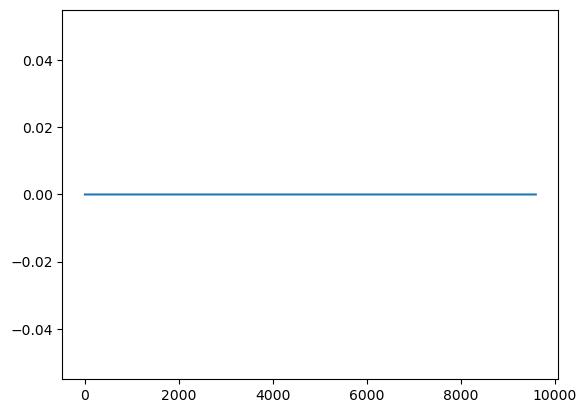

In [16]:


wav1 = np.zeros(2400*2*2, dtype=np.uint16)
inst.send_scpi_cmd(':DIG:DATA:SEL ALL')
inst.send_scpi_cmd(':DIG:DATA:TYPE FRAM')
resp = inst.send_scpi_query(':DIG:DATA:SIZE?')
print(resp)
rc = inst.read_binary_data(':DIG:DATA:READ?', wav1, 2400*2*2)
plt.plot(wav1)
plt.show()

19200


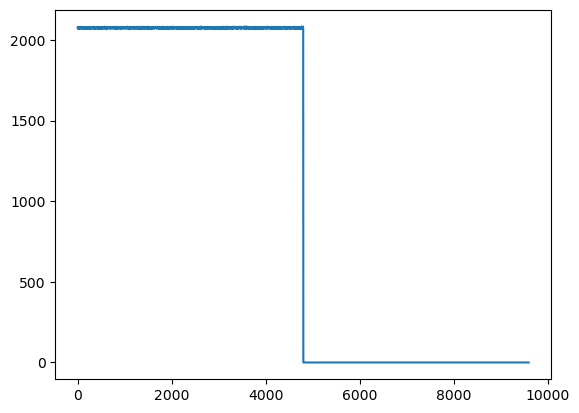

In [16]:
wav1 = np.zeros(4800*2, dtype=np.uint16)
inst.send_scpi_cmd(':DIG:DATA:SEL ALL')
inst.send_scpi_cmd(':DIG:DATA:TYPE FRAM')
resp = inst.send_scpi_query(':DIG:DATA:SIZE?')
print(resp)
rc = inst.read_binary_data(':DIG:DATA:READ?', wav1, 4800*2)
plt.plot(wav1)
plt.show()

In [37]:
def digital_to_analog(signal,bit,voltage_range_pp):
    return -voltage_range_pp/2+(signal/(2**bit-1))*voltage_range_pp

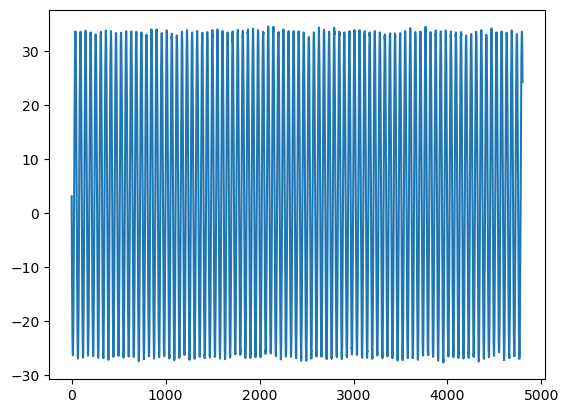

In [38]:
signal=digital_to_analog(wav1,12,250)
plt.plot(signal)